# Машинное обучение, ФКН ВШЭ

# Практическое задание 2

## Общая информация

Дата выдачи: 11.10.2016

Срок сдачи: 24.10.2016 23:59MSK

### О задании
На сайтах для поиска работы можно найти сотни тысяч объявлений, каждое из которых состоит из пространного описания вакансии и предлагаемой зарплаты. Есть ли связь между описанием и зарплатой? Существуют ли определенные слова, которые наиболее сильно характеризуют зарплату? Можно ли найти другие информативные факторы? Вам предстоит ответить на эти вопросы, проанализировав выборку объявлений о работе в Великобритании.

Практическое задание 2 посвящено работе с текстовыми данными и категориальными признаками и задачам бинарной классификации. Вы научитесь:
 * работать с категориальными признаками;
 * строить вещественные представления текстовых данных;
 * обучать и строить прогнозы линейных классификаторов при помощи scikit-learn и Vowpal Wabbit;
 * тестировать модели и проводить оценку качества в задачах бинарной классификации.


### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Кроме того, некоторые из заданий являются опциональными (необязательными), однако за их выполнение можно получить дополнительные баллы, которые позднее будут учитываться при проставлении оценок автоматом по курсу.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW2_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW2_IvanovII.ipynb*). Далее отправьте этот файл на hse.cs.ml+<номер группы>@gmail.com (например, hse.cs.ml+141@gmail.com для студентов группы БПМИ-141).

## Данные

Как было упомянуто ранее, в рамках данного задания мы будем решать задачу бинарной классификации для предсказания уровня заработной платы по тексту объявления о вакансии на примере набора данных с соревнования [Adzuna - Job Salary Prediction](https://www.kaggle.com/c/job-salary-prediction). Для начала пройдите по [ссылке](https://www.kaggle.com/c/job-salary-prediction/data) и скачайте файл Train_rev1 (при необходимости, зарегистрируйтесь на Kaggle).

Посмотрим на данные в файле и загрузим их в DataFrame:

In [1]:
%pylab inline

import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
# print first 2 rows from Train_rev1.csv
!head -n 2 Train_rev1.csv

In [3]:
df = pd.read_csv('Train_rev1.csv', sep=',')
print(df.shape)
df.head()

(244768, 12)


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


В оригинальной постановке предлагается рассматривать признак SalaryNormalized как целевой и решать задачу регрессии, однако в рамках данного задания мы сведём её к задаче бинарной классификации, разделив объекты на 2 группы: объявления о вакансиях с низкой и высокой зарплатами соответственно.

<img src = "http://salt.uaa.alaska.edu/kath/kti/mean_median2.gif">

В качестве порога разбиения объектов на группы будем рассматривать медиану признака SalaryNormalized. Заметим, что таким образом мы автоматически получим задачу классификации со сбалансированными классами:

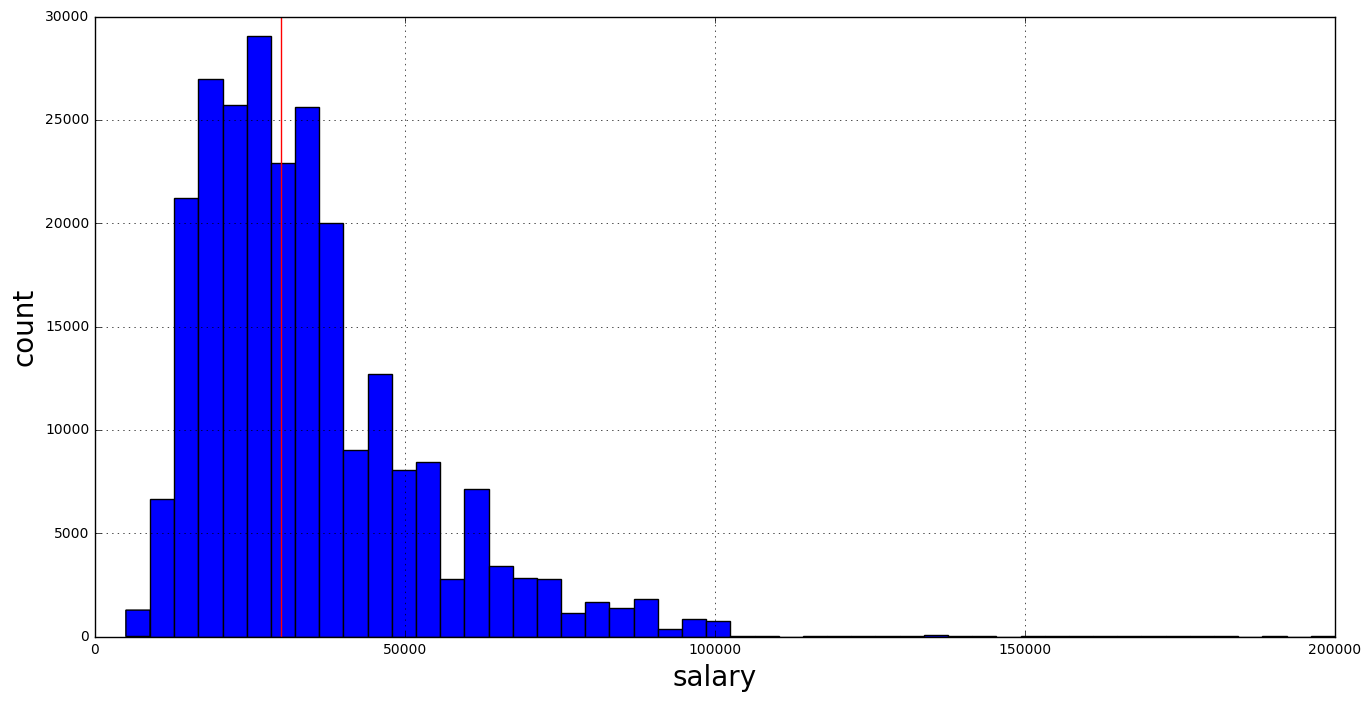

In [4]:
# salary histogramm
median = np.median(df['SalaryNormalized'])

figsize(16,8)
plt.hist(df['SalaryNormalized'], bins=50)
plt.axvline(median, c='r')
plt.xlabel('salary', fontsize=20)
plt.ylabel('count', fontsize=20)
plt.grid()

Осуществим последние шаги по подготовке датасета:
- бинаризуем признак SalaryNomalized по описанному ранее порогу;
- исключим из выборки признак SalaryRaw, чтобы устранить утечку целевой переменной в признаки.

In [5]:
df['SalaryNormalized'] = (df['SalaryNormalized'] > median).astype(int)
df.drop('SalaryRaw', axis=1, inplace=True)
df.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk


#### 1. (0 баллов) Разбейте получившуюся выборку на обучающую и контрольную в соотношении 70/30 с использованием перемешивания объектов.

При разбиении используйте значение параметра random_state=42.

In [7]:
is_testing_mode = False

In [8]:
from sklearn.cross_validation import train_test_split
if is_testing_mode:
    df = df.head(10000)

Y = df['SalaryNormalized']
X = df.drop('SalaryNormalized', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

/root/anaconda3/envs/python/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Векторизация

Как правило, модели, используемые в машинном обучении, применяются в предположении, что матрица "объект-признак" является вещественнозначной. Поэтому при работе с категориальными признаками и текстами сперва их необходимо привести к вещественному виду.

Заметим, что в нашей задаче есть признаки, являющиеся текстами произвольной природы (Title, FullDescription), и категориальные признаки, принимающие ограниченное число значений (ContractType, Category и др.).

Самый простой и понятный способ преобразования текстовых данных — векторизация. В этом случае для каждого слова, встречающегося в некотором набре текстов мы создаём отдельный новый признак, который будет равен $1$, когда слово встречается в заданном объекте, и $0$ – в противном случае.

#### 2. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения всех признаков каждого объекта выборки через символы пробела. После этого получите признаковое описание объектов, осуществив векторизацию получившихся текстов при помощи [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), обучив его на обучающей выборке и применив на контрольной.

In [9]:
def get_text_col(x):
    cat_features_mask = (x.dtypes == "object").values
    data_str = x[x.columns[cat_features_mask]]
    data_str.fillna('nan', inplace=True)
    text = data_str[data_str.columns[0]]
    data_str.columns
    for col in data_str.columns[1:]:
        text += ' ' + data_str[col]
    return text
    
text_train = get_text_col(X_train)
text_test = get_text_col(X_test)

/root/anaconda3/envs/python/lib/python3.5/site-packages/pandas/core/frame.py:2824: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(encoding='utf8', min_df=5)
fit_vect = vectorizer.fit(text_train)

train = vectorizer.transform(text_train)
test = vectorizer.transform(text_test)

#### 3. (1.5 балла) Обучите следующие модели на обучающей выборке:
 - [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из модуля sklearn с параметрами по умолчанию;
 - логистическую регрессию при помощи Vowpal Wabbit с параметрами по умолчанию.

In [11]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression()
logreg.fit(train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
from sklearn.datasets import dump_svmlight_file
dump_svmlight_file(train, y_train, "train.txt")
dump_svmlight_file(test, y_test, "test.txt")
! sed -i 's/^0 /-1 |features /g' train.txt
! sed -i 's/^1 /1 |features /g' train.txt
! sed -i 's/^0 /-1 |features /g' test.txt
! sed -i 's/^1 /1 |features /g' test.txt

In [13]:
! vw --link logistic --loss_function logistic --data train.txt -f model.vw --invert_hash /root/readable_model.vw 

final_regressor = model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = train.txt
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0  -1.0000   0.5000      229
0.611652 0.530157            2            2.0  -1.0000   0.4115       90
0.488651 0.365649            4            4.0  -1.0000   0.2128      168
0.908853 1.329055            8            8.0  -1.0000   0.4008      126
0.802315 0.695778           16           16.0  -1.0000   0.5688      164
0.764599 0.726882           32           32.0  -1.0000   0.6581      194
0.711296 0.657992           64           64.0  -1.0000   0.1751      241
0.685313 0.659331          128          128.0  -1.0000   0.3844      229
0.643729 0.602144          256          256.0  -1.0000   0.2879      122
0.600244 0.556759          512          5

In [14]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

y_pred = logreg.predict(test)
first_linreg_score = roc_auc_score(y_test, y_pred)
first_f1_score = f1_score(y_test, y_pred)
first_cm_score = confusion_matrix(y_test, y_pred)
print(first_linreg_score, first_f1_score, "\n", first_cm_score)

0.873795230883 0.869502686087 
 [[33343  4597]
 [ 4658 30833]]


#### 4. (0.5 балла) Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для каждой из построенных в п. 3 моделей на контрольной выборке. Сравните построенные модели по качеству их работы.

In [15]:
!`vw --data test.txt -t -i model.vw --loss_function logistic -r raw_predictions.txt`

only testing
raw predictions = raw_predictions.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = test.txt
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.843930 0.843930            1            1.0  -1.0000   0.5700      207
0.426326 0.008722            2            2.0  -1.0000   0.0087      235
0.516298 0.606269            4            4.0  -1.0000   0.4590       45
0.337346 0.158395            8            8.0  -1.0000   0.0329      135
0.360707 0.384068           16           16.0   1.0000   0.7549      235
0.270329 0.179952           32           32.0   1.0000   0.7502      154
0.231712 0.193095           64           64.0   1.0000   0.9379      125
0.261072 0.290432          128          128.0   1.0000   0.9207      154
0.293860 0.326649          256          256.0   1.0000   0.4292      231
0.300316 0.306771 

In [16]:
wv_y_pred = []
with open('raw_predictions.txt') as f:
     wv_y_pred = f.readlines()

        
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
wv_y_pred = [1 if float(i) > 0.5 else 0 for i in wv_y_pred]
vw_first_linreg_score = roc_auc_score(y_test, wv_y_pred)

vw_first_f1_score = f1_score(y_test, wv_y_pred)
vw_first_cm_score = confusion_matrix(y_test, wv_y_pred)
print(vw_first_linreg_score, vw_first_f1_score, "\n", vw_first_cm_score)


0.846265866745 0.830915960753 
 [[35064  2876]
 [ 8222 27269]]


#### 5. (1 балл) Отсортируйте веса признаков для модели логистической регрессии из scikit-learn, полученной в п. 2. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретируйте полученный результат.

In [17]:
top_size = 10
indexes = np.argsort([abs(i) for i in logreg.coef_])[0]
columns=vectorizer.get_feature_names()


print('min')
for i in range(0,top_size):
    print(columns[indexes[i]], logreg.coef_[0][indexes[i]])
     
print('max')
for i in range(len(indexes) - top_size,len(indexes)):
    print(columns[indexes[i]], logreg.coef_[0][indexes[i]])
        
#слова действительно похожи на те от которых зависит уровень зарплаты 
# например studentship -- на стажировках платят не много 
# a24 -- какая то компания у которой возможно зарплата как то вделяется на фоне других

min
europeanmanagementaccountant_job -1.97818018542e-06
pm130123 -1.97818018542e-06
alternating -2.25869959099e-06
detailedlevel 7.02977836882e-06
precompletion -7.92821503801e-06
kellieann 8.04741947059e-06
hukins 8.04741947059e-06
visitsdeveloping -1.06720404155e-05
negotiationfor 1.38941874706e-05
v2012 1.92936375553e-05
max
targetjobs 1.52826319491
optometrist 1.59119655352
huntswood 1.6468965302
qsw 1.65384093404
hcpc 1.91340174673
nijobfinder -2.12499628772
a24 2.12845377117
studentship -2.4347189745
elance -3.1993425059
theladders 3.67554320022


#### 6. (0.5 доп. балла) Отсортируйте веса признаков для модели логистической регрессии, полученной в п. 2 при помощи Vowpal Wabbit. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [18]:
import re

def parse_feature_weights():
    with open("readable_model.vw") as f:
        for line in f.readlines():
            mgroup = re.match("^features\^(\d+):(\d+):(.*)$", line)
            if mgroup:
                feature_name = mgroup.group(1)
                feature_weight = mgroup.group(3)
                yield (float(feature_weight), int(feature_name))

result_list = list(parse_feature_weights())
result_list.sort()
columns=vectorizer.get_feature_names()


print('min')
for i in range(0, top_size):
    print(columns[result_list[i][1]], result_list[i][0]) 
    
print('max')
for i in range(len(result_list) - top_size, len(result_list)):
    print(columns[result_list[i][1]], result_list[i][0]) 
    

#слова не очень похожи на те от которых зависит уровень зарплаты 
#theladders -- Ladders, Inc. is a United States-based company providing an online job search service 

min
nijobfinder -1.105152
jobsitnmark -1.104159
findababysitter -1.069271
assistantaccountant_job -1.031723
administrator_job -1.015452
hradministrator_job -0.945075
revitalised -0.943932
assistantmanager_job -0.9249
accountsassistant_job -0.919423
kitchenmanager_job -0.890271
max
legalweekjobs 0.806651
careersinaudit 0.808615
commercialaccountant_job 0.825566
totallyexec 0.874948
actuaryjobs 0.984178
ryanh 0.99589
infochasemedical 1.014803
efinancialcareers 1.177208
oilandgasjobsearch 1.300049
theladders 2.601045


## TF-IDF

Ещё один способ работы с текстовыми данными — [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf) (**T**erm **F**requency–**I**nverse **D**ocument **F**requency). Рассмотрим коллекцию текстов $D$.  Для каждого уникального слова $t$ из документа $d \in D$ вычислим следующие величины:

1. Term Frequency – количество вхождений слова в отношении к общему числу слов в тексте:
$$\text{tf}(t, d) = \frac{n_{td}}{\sum_{t \in d} n_{td}},$$
где $n_{td}$ — количество вхождений слова $t$ в текст $d$.
1. Inverse Document Frequency
$$\text{idf}(t, D) = \log \frac{\left| D \right|}{\left| \{d\in D: t \in d\} \right|},$$
где $\left| \{d\in D: t \in d\} \right|$ – количество текстов в коллекции, содержащих слово $t$.

Тогда для каждой пары (слово, текст) $(t, d)$ вычислим величину:
$$\text{tf-idf}(t,d, D) = \text{tf}(t, d)\cdot \text{idf}(t, D).$$

Отметим, что значение $\text{tf}(t, d)$ корректируется для часто встречающихся общеупотребимых слов при помощи значения $\text{idf}(t, D).$

Признаковым описанием одного объекта $d \in D$ будет вектор $\bigg(\text{tf-idf}(t,d, D)\bigg)_{t\in V}$, где $V$ – словарь всех слов, встречающихся в коллекции $D$.

#### 7. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения всех признаков каждого объекта выборки через символы пробела. После этого получите признаковое описание объектов, вычислив вектор tf-idf для каждого объекта помощи [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), обучив его на обучающей выборке и применив на контрольной.

In [19]:
text_train
text_test
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(encoding='utf8', min_df=5)
_ = vectorizer.fit(text_train)

train = vectorizer.transform(text_train)
test = vectorizer.transform(text_test)


#### 8. (0 баллов) Обучите следующие модели на обучающей выборке:
- [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из модуля sklearn с параметрами по умолчанию;
- логистическую регрессию при помощи Vowpal Wabbit с параметрами по умолчанию.

In [20]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression()
logreg.fit(train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
from sklearn.datasets import dump_svmlight_file
dump_svmlight_file(train, y_train, "train.txt")
dump_svmlight_file(test, y_test, "test.txt")
! sed -i 's/^0 /-1 |features /g' train.txt
! sed -i 's/^1 /1 |features /g' train.txt
! sed -i 's/^0 /-1 |features /g' test.txt
! sed -i 's/^1 /1 |features /g' test.txt
! vw --link logistic --loss_function logistic --data train.txt -f model.vw --invert_hash /root/readable_model.vw 

final_regressor = model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = train.txt
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0  -1.0000   0.5000      229
0.557564 0.421980            2            2.0  -1.0000   0.3443       90
0.444525 0.331487            4            4.0  -1.0000   0.2111      168
0.691462 0.938398            8            8.0  -1.0000   0.4028      126
0.702771 0.714081           16           16.0  -1.0000   0.5447      164
0.708598 0.714425           32           32.0  -1.0000   0.6402      194
0.681388 0.654177           64           64.0  -1.0000   0.2026      241
0.664034 0.646680          128          128.0  -1.0000   0.4226      229
0.630808 0.597582          256          256.0  -1.0000   0.3227      122
0.586339 0.541869          512          5

#### 9. (0.5 балла) Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для каждой из построенных в п. 8 моделей на контрольной выборке. Сравните построенные модели по качеству их работы.

In [22]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

y_pred = logreg.predict(test)

print('roc_auc_score : first:', first_linreg_score, '||', 'second:', roc_auc_score(y_test, y_pred))
print('f1_score : first:', first_f1_score, '||', 'second:', f1_score(y_test, y_pred))
print('confusion_matrix : first:\n', first_cm_score, '\n||', 'second:\n', confusion_matrix(y_test, y_pred))

roc_auc_score : first: 0.873795230883 || second: 0.86874186937
f1_score : first: 0.869502686087 || second: 0.864764738076
confusion_matrix : first:
 [[33343  4597]
 [ 4658 30833]] 
|| second:
 [[32982  4958]
 [ 4679 30812]]


In [23]:
!`vw --data test.txt -t -i model.vw --loss_function logistic -r raw_predictions.txt `

only testing
raw predictions = raw_predictions.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = test.txt
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.837535 0.837535            1            1.0  -1.0000   0.5672      207
0.456690 0.075844            2            2.0  -1.0000   0.0730      235
0.549657 0.642624            4            4.0  -1.0000   0.3498       45
0.314794 0.079931            8            8.0  -1.0000   0.0385      135
0.325506 0.336218           16           16.0   1.0000   0.6582      235
0.229904 0.134303           32           32.0   1.0000   0.7245      154
0.201755 0.173607           64           64.0   1.0000   0.9857      125
0.236962 0.272168          128          128.0   1.0000   0.9349      154
0.288495 0.340028          256          256.0   1.0000   0.6160      231
0.284554 0.280613 

In [24]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

y_pred = []
with open('raw_predictions.txt') as f:
     y_pred = f.readlines()

y_pred = [1 if float(i) > 0.5 else 0 for i in y_pred]

print('roc_auc_score : first:', vw_first_linreg_score, '||', 'second:', roc_auc_score(y_test, y_pred))
print('f1_score : first:', vw_first_f1_score, '||', 'second:', f1_score(y_test, y_pred))
print('confusion_matrix : first:\n', vw_first_cm_score, '\n||', 'second:\n', confusion_matrix(y_test, y_pred))

roc_auc_score : first: 0.846265866745 || second: 0.858757532536
f1_score : first: 0.830915960753 || second: 0.847128138412
confusion_matrix : first:
 [[35064  2876]
 [ 8222 27269]] 
|| second:
 [[34883  3057]
 [ 7166 28325]]


#### 10. (0.5 балла) Сравните значения метрик из п. 9 со значениями, полученными в п. 5, и сравните соответствующие модели по качеству из работы.

**Ответ**: В случае логистической регрессии из sklearn  значение auc-roc и f1_score уменьшилось, так же по матрице ошибок видно что мы стали делать меньше обштбок второго рода и больше первого рода.

 В случае логистической регрессии из vw  значение auc-roc и f1_score наоборот увеличилось, так же по матрице ошибок видно что мы стали делать меньше обштбок первого рода но больше второго рода.

#### 11. (1 балл) Отсортируйте веса признаков для каждой из полученных в п. 8 моделей. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [25]:
indexes = np.argsort([abs(i) for i in logreg.coef_])[0]
columns=vectorizer.get_feature_names()


print('min')
for i in range(0,top_size):
    print(columns[indexes[i]], logreg.coef_[0][indexes[i]])
     
print('max')
for i in range(len(indexes) - top_size,len(indexes)):
    print(columns[indexes[i]], logreg.coef_[0][indexes[i]])
        
#слова действительно похожи на те от которых зависит уровень зарплаты  -- гораздо лучше чем предыдущие способы 
# все слова очевидно напрямую связанные с зрплатой -- senior -- junior --  manager -- director -- graduate(лол -10.0480773619) 

min
todayhays 2.41610720242e-06
whitepertemps 5.85486935195e-06
recyling -1.25834673976e-05
copes 2.28314253222e-05
livingstone 2.79225185686e-05
sportsmark -3.33801069691e-05
refurbishing -3.94882212767e-05
cwsmeriaid 4.28973672333e-05
iniative 4.78632365809e-05
requited 4.92168915345e-05
max
london 6.2765960921
head 7.07286693571
jobcentre -7.33165899363
senior 7.39313841688
junior -7.77731735176
manager 7.78582669035
director 7.79908643596
optometrist 8.8772196722
graduate -10.0480773619
assistant -10.8988826337


#### 12. (0.5 доп. балла) Отсортируйте веса признаков для модели логистической регрессии, полученной в п. 8 при помощи Vowpal Wabbit. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [26]:
import re

def parse_feature_weights():
    with open("readable_model.vw") as f:
        for line in f.readlines():
            mgroup = re.match("^features\^(\d+):(\d+):(.*)$", line)
            if mgroup:
                feature_name = mgroup.group(1)
                feature_weight = mgroup.group(3)
                yield (abs(float(feature_weight)), int(feature_name))

result_list = list(parse_feature_weights())
result_list.sort()
columns=vectorizer.get_feature_names()


print('min')
for i in range(0, top_size):
    print(columns[result_list[i][1]], result_list[i][0]) 
    
print('max')
for i in range(len(result_list) - top_size, len(result_list)):
    print(columns[result_list[i][1]], result_list[i][0]) 
    

#слова действительно похожи на те от которых зависит уровень зарплаты 
#  theladders -- сайт с вакансиями -- видимо это какой то сайт на котором размещают васокооплачиваемую работу 

min
stokenchurch 0.000135
ecom 0.000151
nes 0.000158
lifelimiting 0.000213
blumenthal 0.000279
engraving 0.000279
graphics 0.000283
coffees 0.000322
collaborations 0.000369
kk 0.000389
max
revitalised 8.309172
crowncarveries 8.309795
milkmen 8.377786
vehiclepurchasercarsales_job 8.381116
airmonitoring 8.440272
spoton 8.77332
hearingcareflamehealth 8.975466
navisionjobs 9.648344
yearscoring 13.331036
theladders 16.332384


## Счётчики

Ранее в рамках данного задания при построении моделей мы объединяли значения всех признаков в единую строку, что предполагает равноправность всех признаков. Однако заметим, что в этом случае мы допускаем потерю информации: слово "Glasgow" может по-разному влиять на зарплату, если оно находится в названии объявления и в геолокации. Чтобы устранить этот недостаток, при создании текстового описания объекта будем объединять только значения признаков Title и FullDescription, а остальные будем рассматривать как категориальные. При этом с полученным текстовым описанием объекта будем работать, как раньше (при помощи векторизации или tf-idf), а для кодирования категориальных признаков используем **счётчики**.

Идея этого метода состоит в том, чтобы заменить значение категориального признака на вероятность того, что объект с данным значением признака относится к положительному классу. Опишем эту идею более формально. Пусть у нас есть выборка $X = \{ (x_i, y_i) \}_{i=1}^l,$ и $j$-ый признак принимает значения из множества $U_j = \{ u_{jn}\}_{n=1}^{N_j},$ где $N_j$ — количество различных значений $j$-ого признака. Пусть $x_{ij} = u_{jn},$ тогда заменим значения $j$-ого категориального признака объекта $x_i$ на следующую оценку: 
$$\hat{P}(y_i=+1|x_{ij}=u_{jn}) = \frac{\sum_{m=1}^l \left[ x_{mj} = u_{jn} \right] \left[ y_m = +1 \right]}{\sum_{m=1}^l \left[ x_{mj} = u_{jn} \right]}.$$

Однако заметим, что при таком способе формирования счётчиков мы учитываем в формуле для объекта $x_i$ его метку $y_i$, тем самым вносим информацию об ответе в признаки. Чтобы устранить этот недостаток, при вычислении счётчика будем исключать из рассмотрения текущий объект, т.е. рассматривать следующую оценку:
$$\hat{P}(y_i=+1|X_{ij}=u_{jn}) = \frac{\sum_{m=1, \\ m \ne i}^l \left[ x_{mj} = u_{jn} \right] \left[ y_m = +1 \right]}{\sum_{m=1, \\ m \ne i}^l \left[ x_{mj} = u_{jn} \right]},$$

#### 13. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения признаков Title и FullDescription каждого объекта выборки через символ пробела, после чего перейдите к признаковому описанию объектов, вычислив вектор tf-idf аналогично п. 7. (будет сделано в одной куче с 14 номером)

#### 14. (1 балл) Закодируйте категориальные признаки (все, кроме Title и FullDescription) при помощи [one-hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), после чего обучите логистическую регрессию (при помощи scikit-learn или Vowpal Wabbit) на обучающей выборке. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для полученной модели на контрольной выборке. 

In [1]:
#cчкачиваю выборку

import pandas as pd
import numpy as np
df = pd.read_csv('Train_rev1.csv', sep=',')
print(df.shape)
df.head()
median = np.median(df['SalaryNormalized'])

df['SalaryNormalized'] = (df['SalaryNormalized'] > median).astype(int)
df.drop('SalaryRaw', axis=1, inplace=True)
df.drop('LocationRaw', axis=1, inplace=True)
df.drop('Id', axis=1, inplace=True)
df.head()

from sklearn.cross_validation import train_test_split

Y = df['SalaryNormalized']
X = df.drop('SalaryNormalized', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

(244768, 12)


/root/anaconda3/envs/python/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#беру от каждой компании только одно объявление а то все не влезает в память поэтому приходится оптимизировать
companies = {}
max_count = 1
to_delete = []

print(X_train.shape)
print(y_train.shape)

for i in range(0, X_train.shape[0]):
    comp = X_train.iloc[i]['Company']
    companies.setdefault(comp, 0)
    companies[comp] += 1
    if companies[comp] > max_count:
        to_delete += [i] 


(171337, 8)
(171337,)


In [3]:
#удаляю ненужные данные из сета
len(to_delete)
X_train.drop(X_train.index[to_delete], inplace=True)
y_train.drop(y_train.index[to_delete], inplace=True)
print(X_train.shape)
print(y_train.shape)

(17751, 8)
(17751,)


/root/anaconda3/envs/python/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [4]:
#Делю сет на две кучи
text_train = X_train['Title'] + ' ' + X_train['FullDescription']
text_test = X_test['Title'] + ' ' + X_test['FullDescription']
text_train.fillna('nan', inplace=True)
X_train.drop(['Title', 'FullDescription'], inplace=True, axis=1)
X_test.drop(['Title', 'FullDescription'], inplace=True, axis=1)


/root/anaconda3/envs/python/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/root/anaconda3/envs/python/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
#делаю LabelEncoder признаков
cat_features_mask = (X_train.dtypes == "object").values 
print(cat_features_mask)
print(X_train.columns)
df.fillna('nan', inplace=True)
X_train.fillna('nan', inplace=True)
X_test.fillna('nan', inplace=True)

from sklearn import preprocessing
X_train.head()
label_enc = preprocessing.LabelEncoder()
for feature in X_train.columns[cat_features_mask]: 
    label_enc.fit(df[feature])
    X_train[feature] = label_enc.transform(X_train[feature])
    X_test[feature] = label_enc.transform(X_test[feature])


[ True  True  True  True  True  True]
Index(['LocationNormalized', 'ContractType', 'ContractTime', 'Company',
       'Category', 'SourceName'],
      dtype='object')


/root/anaconda3/envs/python/lib/python3.5/site-packages/pandas/core/frame.py:2824: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/root/anaconda3/envs/python/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/root/anaconda3/envs/python/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

In [6]:
#делаю OneHotEncoder для трейна
enc = preprocessing.OneHotEncoder(sparse=False)

X_cat_np = enc.fit_transform(
    X_train[
        X_train.columns[cat_features_mask]
    ]
)
X_cat_pd = pd.DataFrame(data=X_cat_np)

In [7]:
# делаю TfidfVectorizer для трейна 
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(encoding='utf8', min_df=5)
train = vectorizer.fit_transform(text_train)


In [8]:
#записываю для vw в файл  трейн
from sklearn.datasets import dump_svmlight_file
print(pd.DataFrame(train.todense()).shape)
print(X_cat_pd.shape)
dump_svmlight_file(pd.concat([pd.DataFrame(train.todense()), X_cat_pd], axis=1), y_train, "train.txt")

(17751, 13350)
(17751, 19270)


In [9]:
#обучаю vw на тестовых 
! ./run_vw
# те же команды что и в предыдущих номерах толкьо в одном файле

final_regressor = model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = train.txt
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0  -1.0000   0.5000      226
0.542842 0.392536            2            2.0  -1.0000   0.3247       87
0.449483 0.356125            4            4.0  -1.0000   0.2285      168
0.676287 0.903091            8            8.0  -1.0000   0.4008      118
0.703580 0.730873           16           16.0  -1.0000   0.5433      160
0.703952 0.704324           32           32.0  -1.0000   0.6265      188
0.691287 0.678622           64           64.0   1.0000   0.5292      211
0.662779 0.634270          128          128.0   1.0000   0.4887      131
0.616999 0.571219          256          256.0  -1.0000   0.5508      344
0.572844 0.528690          512          5

In [10]:
# нахожу в тесте признаки имеющие большие чем в трейне значения и удаляю потому что если это не сделать то не получится заикодить
to_delete = []

for r in range(0, X_test.shape[0]):
    row = X_test.iloc[r]
    if (row >= enc.n_values_).any(): 
        to_delete += [r]


In [11]:
to_delete

[24746, 71926]

In [12]:
# удаляю из тестовой выборки ненужные строчки
print(X_test.shape)
X_test.drop(X_test.index[to_delete], inplace=True)
print(X_test.shape)

print(text_test.shape)
text_test.drop(text_test.index[to_delete], inplace=True)
print(text_test.shape)
test = vectorizer.transform(text_test)
print(y_test.shape)
y_test.drop(y_test.index[to_delete], inplace=True)
print(y_test.shape)

(73431, 6)
(73429, 6)
(73431,)
(73429,)


/root/anaconda3/envs/python/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


(73431,)
(73429,)


In [13]:
#делаю OneHotEncoder для теста
X_test_cat_np = enc.transform(
    X_test[
        X_test.columns[cat_features_mask]
    ]
)
X_test_cat_pd = pd.DataFrame(data=X_test_cat_np)


In [14]:
del train
del X_cat_pd
del df
del enc
del label_enc 
import gc
gc.collect()

81

In [15]:
print(pd.DataFrame(test.todense()).shape)
print(X_test_cat_pd.shape)
test = pd.concat([pd.DataFrame(test.todense()).head(17000), X_test_cat_pd.head(17000)], axis=1)

(73429, 13350)
(73429, 19270)


In [17]:
#записываю для vw в файл  трейн
def print_for_vw(X, y, file_name):
    f = open(file_name, 'w')
    for i in range(X.shape[0]):
        f.write(str(int(y.values[i])))
        f.write(" |features")
        for c in range(len(X.columns)):
            f.write(" ")
            f.write(str(c))
            f.write(":")
            f.write(str(X.iloc[i][X.columns[c]]))
        f.write("\n")
    f.close()

print(test.shape)
print(y_test.shape)
dump_svmlight_file(test, y_test.head(17000), "test.txt")

(17000, 32620)
(73429,)


In [18]:
! ./predict_vw 
# те же команды что и в предыдущих номерах толкьо в одном файле

only testing
raw predictions = raw_predictions.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = test.txt
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.846529 0.846529            1            1.0  -1.0000   0.5711      204
0.665855 0.485182            2            2.0  -1.0000   0.3844      225
0.704473 0.743090            4            4.0  -1.0000   0.5951       43
0.441444 0.178415            8            8.0  -1.0000   0.1242      132
0.417861 0.394279           16           16.0   1.0000   0.7790      230
0.383540 0.349220           32           32.0   1.0000   0.6426      150
0.320767 0.257993           64           64.0   1.0000   0.9657      123
0.326298 0.331829          128          128.0   1.0000   0.8524      148
0.356761 0.387224          256          256.0   1.0000   0.4788      209
0.362364 0.367968 

In [21]:
wv_y_pred = []
with open('raw_predictions.txt') as f:
     wv_y_pred = f.readlines()

        
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
wv_y_pred = [1 if float(i) > 0.5 else 0 for i in wv_y_pred]
vw_first_linreg_score = roc_auc_score(y_test.head(17000), wv_y_pred)

vw_first_f1_score = f1_score(y_test.head(17000), wv_y_pred)
vw_first_cm_score = confusion_matrix(y_test.head(17000), wv_y_pred)
print(vw_first_linreg_score, vw_first_f1_score, "\n", vw_first_cm_score)

#хначения хуже чем с предыдущих но скорее всего это вызвано тем что в данном случае из за one-hot признаки очень сиьно размножаются
# поэтому мне было невозможно работать со всей выборкой поскольку оперативная память полностью исчерпывалась

0.795344304259 0.764665286404 
 [[8050  736]
 [2674 5540]]


#### 15. (2 балла) Для выборки, полученной в п. 13, закодируйте категориальные признаки (все, кроме Title и FullDescription) при помощи счётчиков, после чего обучите логистическую регрессию (при помощи scikit-learn или Vowpal Wabbit) на обучающей выборке. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для полученной модели на контрольной выборке. 

Уделите внимание оптимальности вычисления счётчиков!

#### 16. (0.5 балла) Сравните значения метрик из п. 15 со значениями, полученными в п. 14, и сделайте вывод о качестве классификации для каждого из методов кодирования категориальных признаков.

**Ответ:**

## Подбор гиперпараметров

#### 17. (1.5 доп. балла) Разбейте обучающую выборку на обучающую и валидационную в отношении 80/20. Для выборки, полученной в п. 13, подберите оптимальное количество фолдов, используемое при кодировании категориальных признаков (всех, кроме Title и FullDescription), путём оптимизации значения accuracy на валидационной выборке. Используйте следующие модели, аналогично также подобрав оптимальные значения указанных гиперпараметров:
- логистическую регрессию из модуля sklearn с подбором коэффициента регуляризации;
- логистическую регрессию при помощи Vowpal Wabbit с подбором следующих гиперпараметров:
    - коэффициент регуляризации (--l2);
    - количество эпох (--passes);
    - длина градиентного шага (-l);
    - длина N-грамм (--ngram).

In [ ]:
# Your code here

#### 18. (0.5 доп. балла) Обучите указанные выше модели на обучающей выборке для оптимальных значений гиперпараметров, найденных в п. 17, после чего для каждой из моделей вычислите значения ROC-AUC, F-меры, а также постройте матрицу ошибок на контрольной выборке. Как качество классификации при помощи полученных в данном разделе моделей соотносится с моделями, полученными в предыдущих разделах?

In [ ]:
# Your code here

Здесь вы можете поделиться своими мыслями по поводу этого задания.

А здесь — вставить вашу вторую любимую смешную картинку.

А здесь — посоветовать преподавателям хороший фильм или сериал.